# ATLAS RPV CNN Classifier notebook

Mostly taken from Michela's Keras implementation here: https://github.com/mickypaganini/susy_rpv/blob/micky/train.py

* TODO: improve documentation.
* TODO: add some relevant callbacks such as early stopping.
* TODO: run on a full Haswell batch node.
* TODO: tinker with the TF thread settings.

In [1]:
# Device and concurrency settings
import os
os.environ['OMP_NUM_THREADS'] = '4'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
from __future__ import print_function
from __future__ import division

import h5py
import numpy as np

from keras import optimizers

from sklearn import metrics
import matplotlib.pyplot as plt

from rpv import build_model, train_model

%matplotlib notebook

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Global configuration

In [3]:
# Data config
n_train = 64000 #412416
n_valid = 32000 #137471
n_test = 32000 #137471

## Load the data

In [4]:
input_dir = '/data0/users/sfarrell/atlas-rpv-images'

In [5]:
ls -lh $input_dir

total 1.8G
-rw-rw---- 1 sfarrell sfarrell 358M Apr 24 14:32 test.h5
-rw-rw---- 1 sfarrell sfarrell 1.1G Apr 24 14:32 train.h5
-rw-rw---- 1 sfarrell sfarrell 358M Apr 24 14:32 val.h5


In [6]:
def load_file(file, n_samples):
    print('Loading file', file)
    with h5py.File(file) as f:
        data_group = f['all_events']
        print('Loading %i/%i events' %
              (n_samples, data_group['hist'].shape[0]))
        data = data_group['hist'][:n_samples][:,:,:,None]
        labels = data_group['y'][:n_samples]
        weights = data_group['weight'][:n_samples]
    return data, labels, weights

In [7]:
%%time

train_file = os.path.join(input_dir, 'train.h5')
valid_file = os.path.join(input_dir, 'val.h5')
test_file = os.path.join(input_dir, 'test.h5')

train_input, train_labels, train_weights = load_file(train_file, n_train)
valid_input, valid_labels, valid_weights = load_file(valid_file, n_valid)
test_input, test_labels, test_weights = load_file(test_file, n_test)

Loading file /data0/users/sfarrell/atlas-rpv-images/train.h5
Loading 64000/412416 events
Loading file /data0/users/sfarrell/atlas-rpv-images/val.h5
Loading 32000/137471 events
Loading file /data0/users/sfarrell/atlas-rpv-images/test.h5
Loading 32000/137471 events
CPU times: user 12.9 s, sys: 1.3 s, total: 14.2 s
Wall time: 14.2 s


In [8]:
print('train shape:', train_input.shape)
print('valid shape:', valid_input.shape)
print('test shape: ', test_input.shape)

train shape: (64000, 64, 64, 1)
valid shape: (32000, 64, 64, 1)
test shape:  (32000, 64, 64, 1)


## Define the model

## Train the model

In [9]:
# Model config
h1, h2, h3, h4, h5 = 64, 128, 256, 256, 512
optimizer = 'Adam'
#optimizer = optimizers.Adam

In [10]:
# Training config
batch_size = 128
n_epochs = 4
use_weights = False

In [11]:
model = build_model(train_input.shape[1:],
                    h1=h1, h2=h2, h3=h3, h4=h4, h5=h5,
                    optimizer=optimizer)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 256)       295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 256)       590080    
_________________________________________________________________
flatten_1 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               33554944  
__________

In [12]:
# Train the model
history = train_model(model, train_input=train_input, train_labels=train_labels,
                      valid_input=valid_input, valid_labels=valid_labels,
                      batch_size=batch_size, n_epochs=n_epochs, verbose=1)

Train on 64000 samples, validate on 32000 samples
Epoch 1/4
64000/64000 [==============================] - 56s 880us/step - loss: 0.2655 - acc: 0.8899 - val_loss: 0.2378 - val_acc: 0.9046
Epoch 2/4
64000/64000 [==============================] - 51s 802us/step - loss: 0.2361 - acc: 0.9049 - val_loss: 0.2299 - val_acc: 0.9072
Epoch 3/4
64000/64000 [==============================] - 52s 810us/step - loss: 0.2345 - acc: 0.9054 - val_loss: 0.2303 - val_acc: 0.9063
Epoch 4/4
64000/64000 [==============================] - 52s 807us/step - loss: 0.2314 - acc: 0.9067 - val_loss: 0.2469 - val_acc: 0.9001


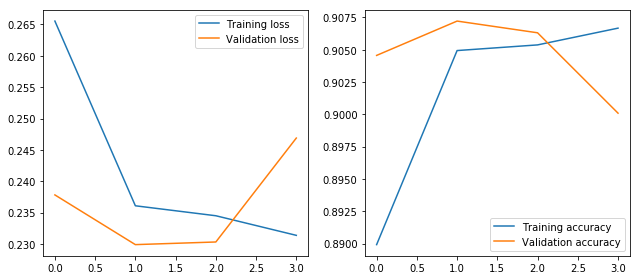

In [13]:
plt.figure(figsize=(9,4))
plt.subplot(121)
plt.plot(history.epoch, history.history['loss'], label='Training loss')
plt.plot(history.epoch, history.history['val_loss'], label='Validation loss')
plt.legend(loc=0)
plt.subplot(122)
plt.plot(history.epoch, history.history['acc'], label='Training accuracy')
plt.plot(history.epoch, history.history['val_acc'], label='Validation accuracy')
plt.legend(loc=0)
plt.tight_layout()

## Evaluate on the test set

In [14]:
def summarize_metrics(labels, outputs, threshold=0.5, weights=None):
    preds = outputs > threshold
    print('Metrics summaries with threshold of %.3f' % threshold)
    print('Accuracy:   %.4f' % metrics.accuracy_score(labels, preds, sample_weight=weights))
    print('Purity:     %.4f' % metrics.precision_score(labels, preds, sample_weight=weights))
    print('Efficiency: %.4f' % metrics.recall_score(labels, preds, sample_weight=weights))

def draw_roc(labels, outputs, weights=None, ax=None):
    fpr, tpr, _ = metrics.roc_curve(labels, outputs, sample_weight=weights)
    auc = metrics.roc_auc_score(labels, outputs, sample_weight=weights)
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(fpr, tpr, label='CNN, AUC=%.3f' % auc)
    ax.plot([0, 1], [0, 1], '--', label='Random')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.legend(loc=0)

In [15]:
test_output = model.predict(test_input)
test_output = test_output.squeeze(-1)

In [16]:
# Unweighted results
summarize_metrics(test_labels, test_output)

Metrics summaries with threshold of 0.500
Accuracy:   0.8988
Purity:     0.8244
Efficiency: 0.9695


In [17]:
# Weighted results
summarize_metrics(test_labels, test_output, weights=test_weights)

Metrics summaries with threshold of 0.500
Accuracy:   0.0723
Purity:     0.0001
Efficiency: 0.9695


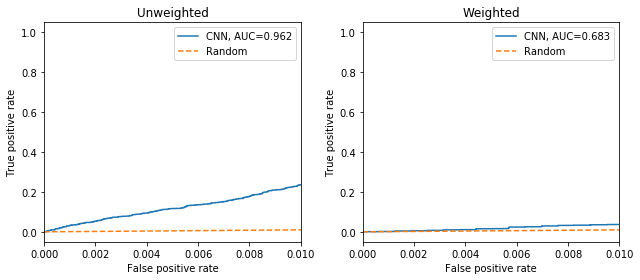

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(9,4))
draw_roc(test_labels, test_output, ax=axs[0])
draw_roc(test_labels, test_output, ax=axs[1], weights=test_weights)
axs[0].set_xlim([0, 0.01])
axs[0].set_title('Unweighted')
axs[1].set_xlim([0, 0.01])
axs[1].set_title('Weighted')
plt.tight_layout()

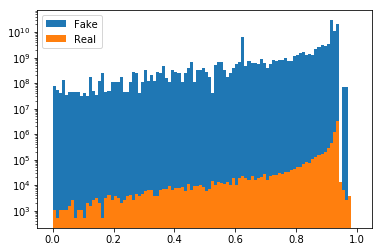

In [19]:
# Visualize the model output
plt.figure()

# Select real/fake sample model outputs
real_idx = test_labels > 0.5
fake_idx = (real_idx == False)

binning=dict(bins=100, range=(0, 1), log=True)
plt.hist(test_output[fake_idx], weights=test_weights[fake_idx], label='Fake', **binning)
plt.hist(test_output[real_idx], weights=test_weights[real_idx], label='Real', **binning)
plt.legend(loc=0);